# The Two-Team Factor: Gender in March Madness

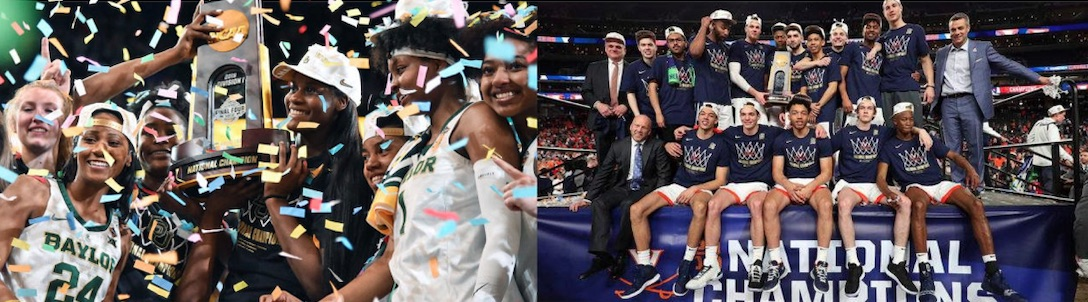

### The purpose of this notebook is to explore the connection between Men and Women's NCAA Basketball. 


**We want to know whether the success of one program has any effect on the other?**

We seek to establish a factor based on this connection that can be used to predict the performance of a team in the NCAA Tournament.
The factor being examined is whether a college program that has both a men's and women's team participating in the NCAA Tournament in the same season will perform better than a program that only has a single team participating. We will call this the **"Two-Team Factor."**

We will call programs that have both Men's and Women's teams playing in the tournament Two-Team Programs, and programs that have only a men's or a women's team competing Single Team Programs.

### Table of Contents
1. Introduction
2. Preparations
    * 2.1 Creating Dataframes
    * 2.2 Add Tournament Rounds    
3. Exploration
    * 3.1 Breakdown of Teams in Each Round
    * 3.2 Win Percentage per Round
    * 3.3 By Season   
    * 3.4 Two-Team Programs vs Single Team Programs    
4. Other Factors
    * 4.1 PPG
    * 4.2 Seed
    * 4.3 Conference  
5. Conclusion
    

# 1. Introduction

March Madness is a special time of year. Fans are able to root for their favorite teams in a single elimination tournament that crowns the champion of College Basketball. We have two opportunities to watch our favorite teams because both the Men's and Women's NCAA Tournaments happen in March. Some lucky fans even get the opportunity to cheer for both teams at the same time. But this isn't the only reason they are lucky. When a school's men's and women's teams are competing in the tournament, they're actually more likely to win.

**We start with a simple hypothesis:** NCAA Division I Basketball programs that have both a Women and Men's team participating in the NCAA Tournament in the same season, perform better than teams that do not. 

**The Goal** is to show that there is evidence in the historical data to suggest this phenomenon exists, and this "Two-team" factor can be used in predicting the outcome of future tournament games.

**The Data:** We will be using tournament and regular season data from both the women's and men's data files in this competition.

In general, we don't consider Men's and Women's games to be related. They do not share a coach, players, or even the same strategies. However, programs that have two teams participating in the tournament appear to be much more competitive than programs that only have one. In tournament play, we see Two-Team Programs win at a much higher rate, and as a result, consistently make it futher in the tournamnet than Single team programs. We think this phenomenon makes sense both empirically and logically . If one team at a school (men or women) becomes dominant it is likely this attracts more fans, increases ticket sales, and eventually impacts other sports programs at the university, creating a kind of loop where if one basketball team is good the other one builds off of this. 



# 2. Preparations

Loading the libraries and data:

In [ ]:
# Import libraries
import numpy as np
#import warnings
#warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd 
from datetime import date, timedelta
from sklearn import preprocessing

# Vizualizations
!pip install joypy
import joypy
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.express as px
from scipy import stats
from matplotlib.pyplot import figure
plt.style.use('seaborn-whitegrid')
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore")

# This prints out the path (or directory) for each file so I 
#can use that to import it when needed.
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
# Load data
# Women Data
WTeams = pd.read_csv('/kaggle/input/march-madness-analytics-2020/2020DataFiles/2020DataFiles/2020-Womens-Data/WDataFiles_Stage1/WTeams.csv')
WTourney_comp = pd.read_csv('/kaggle/input/march-madness-analytics-2020/2020DataFiles/2020DataFiles/2020-Womens-Data/WDataFiles_Stage1/WNCAATourneyCompactResults.csv')
Wreg_season_comp = pd.read_csv('/kaggle/input/march-madness-analytics-2020/2020DataFiles/2020DataFiles/2020-Womens-Data/WDataFiles_Stage1/WRegularSeasonCompactResults.csv')
WConferences = pd.read_csv('/kaggle/input/march-madness-analytics-2020/2020DataFiles/2020DataFiles/2020-Womens-Data/WDataFiles_Stage1/WTeamConferences.csv')
WSeeds = pd.read_csv('/kaggle/input/march-madness-analytics-2020/2020DataFiles/2020DataFiles/2020-Womens-Data/WDataFiles_Stage1/WNCAATourneySeeds.csv')

# Men Data
MTeams = pd.read_csv('/kaggle/input/march-madness-analytics-2020/2020DataFiles/2020DataFiles/2020-Mens-Data/MDataFiles_Stage1/MTeams.csv')
MTourney_comp = pd.read_csv('/kaggle/input/march-madness-analytics-2020/2020DataFiles/2020DataFiles/2020-Mens-Data/MDataFiles_Stage1/MNCAATourneyCompactResults.csv')
Mreg_season_comp = pd.read_csv('/kaggle/input/march-madness-analytics-2020/2020DataFiles/2020DataFiles/2020-Mens-Data/MDataFiles_Stage1/MRegularSeasonCompactResults.csv')
MConferences = pd.read_csv('/kaggle/input/march-madness-analytics-2020/2020DataFiles/2020DataFiles/2020-Mens-Data/MDataFiles_Stage1/MTeamConferences.csv')
MSeeds = pd.read_csv('/kaggle/input/march-madness-analytics-2020/2020DataFiles/2020DataFiles/2020-Mens-Data/MDataFiles_Stage1/MNCAATourneySeeds.csv')

## 2.1 Creating Dataframes

First, we are going to create our own data frame using the data supplied for this competition. The data in this competition consists of regular season and tournament data for Men and Women's teams competing in the NCAA Tournament. We are going to create new datasets for the Women and Men's teams, as we will incorporate both sets of data into our analysis. 

This data frame will show every team that has competed in the tournament from the seasons 1998-2019. We use the same time frame for both men's and women's tournaments. It will include relevant features such as the Seed of the team and their historical points per game (PPG), as well as a feature for our Two-Team Factor. 

### Women Teams

In [ ]:
# Give the teams names
W_results = WTourney_comp.merge(WTeams, left_on='WTeamID',right_on = 'TeamID',
                                validate='many_to_one').drop('TeamID',axis=1).rename(columns={'TeamName':'WTeamName'})\
                        .merge(WTeams, left_on='LTeamID', right_on = 'TeamID',
                        validate='many_to_one').drop('TeamID',
                                                          axis=1).rename(columns={'TeamName':'LTeamName'})


# Number of wins in tournament per team
def Wppg_wins(season_data):
    ls = season_data[['Season','WTeamName', 'WScore']].groupby(['Season','WTeamName'])['WScore'].mean()
    df = pd.DataFrame(ls) #puts data into pandas dataframe
    df['Num_wins'] = season_data.groupby('Season').WTeamName.value_counts()
    dff = df.reset_index().rename(columns = {'WTeamName': 'TeamName'}) 
    return dff

def Wppg_loss(season_data):
    ls = season_data[['Season','LTeamName', 'LScore']].groupby(['Season','LTeamName'])['LScore'].mean()
    df = pd.DataFrame(ls)   #puts data into pandas dataframe
    dff = df.reset_index().rename(columns = {'LTeamName': 'TeamName'}) 
    return dff


Wom_gw = Wppg_wins(W_results)
Wom_gl = Wppg_loss(W_results)

# merge
Womens_Tournament = pd.merge(Wom_gl, Wom_gw, on=['Season','TeamName'], how='outer', indicator='FirstRound', sort='Season')

# fill the missing values(NaN) with 0 because those teams have no wins in the tournament
# drop FirstRound
Womens_Tournament = Womens_Tournament.drop(['LScore', 'WScore','FirstRound'], axis=1)
Womens_Tournament['Num_wins'].fillna(0, inplace=True)

Womens_Tournament.head()

#### Add a points per game (PPG), Seed, and Conference Column

We are building a dataframe with common factors associated with tournament performance: Points per Game (PPG), Seed, and Conference

In [ ]:
# Get the ppg from regular season
W_ppg = Wreg_season_comp.merge(WTeams, left_on='WTeamID',right_on = 'TeamID',
                                validate='many_to_one').drop('TeamID',axis=1).rename(columns={'TeamName':'WTeamName'})\
                        .merge(WTeams, left_on='LTeamID', right_on = 'TeamID',
                        validate='many_to_one').drop('TeamID',
                                                          axis=1).rename(columns={'TeamName':'LTeamName'})

                                                                             


# We make a datafram from the regular season data 
def Wppg_wins(season_data):
    #gathers the avg ppg for each team in each season
    ls = season_data[['Season','WTeamName', 'WScore']].groupby(['Season','WTeamName'])['WScore'].mean().round(3)
    df = pd.DataFrame(ls) #puts data into pandas dataframe
    df['Num_wins'] = season_data.groupby('Season').WTeamName.value_counts()
    dff = df.reset_index().rename(columns = {'WTeamName': 'TeamName'}) 
    return dff

def Wppg_loss(season_data):
    #gathers the avg ppg for each team in each season
    ls = season_data[['Season','LTeamName', 'LScore']].groupby(['Season','LTeamName'])['LScore'].mean().round(3)
    df = pd.DataFrame(ls)   #puts data into pandas dataframe
    dff = df.reset_index().rename(columns = {'LTeamName': 'TeamName'}) 
    return dff

Wom_ppgw = Wppg_wins(W_ppg)
Wom_ppgl = Wppg_loss(W_ppg)


# merge
Womens_Season = pd.merge(Wom_ppgl, Wom_ppgw, on=['Season','TeamName'], how='outer', indicator='FirstRound', sort='Season')
# Create PPG column
Womens_Season['PPG'] = Womens_Season[['LScore', 'WScore']].mean(axis=1)
# fill Num_wins NaN with 0
Womens_Season = Womens_Season.drop(['LScore', 'WScore','FirstRound'], axis=1)
Womens_Season['Num_wins'].fillna(0, inplace=True)

# Now we combine the regular season data with the tournament data
Womens_ppg = pd.merge(Womens_Tournament, Womens_Season, on=['Season','TeamName'], how='outer', indicator='Tour', sort='Season')
Womens_Tournament = Womens_ppg.loc[Womens_ppg['Tour'] == "both"]
Womens_Tournament = Womens_Tournament.drop(['Num_wins_y', 'Tour'], axis=1).rename(columns={'Num_wins_x': 'Num_wins'})

# Add seed column by merging datasets
W_Seeds = WSeeds.merge(WTeams, on= 'TeamID', how='left', validate='many_to_one')
W_Seeds = W_Seeds.drop('TeamID', axis=1)
# merge the seed and tournament data
Womens_Tournament = pd.merge(Womens_Tournament, W_Seeds, on=['Season','TeamName'], how='left' , sort='Season')
# Make region and seed into separate columns
Womens_Tournament['Region'] = Womens_Tournament['Seed'].apply(lambda x: x[0][:1])
Womens_Tournament['Seed'] = Womens_Tournament['Seed'].apply(lambda x: int(x[1:3]))

# Conference
W_Conference = WConferences.merge(WTeams, on= 'TeamID', how='left', validate='many_to_one')
W_Conference = W_Conference.drop('TeamID', axis=1)

# add column
Womens_Tournament= pd.merge(Womens_Tournament, W_Conference, on=['Season','TeamName'], how='left' , sort='Season')
Womens_Tournament.head()

**Add the Two-Team Factor (or Both Column)**

This is the column that describes our factor. This columns signifies whether a women's program also has a men's team in the Men's NCAA Tournament in the same year. We use the name Both because this feature tells us whether or not a program has both teams participating. Both will equal **1** if there are two teams and **0** if there is only a Women's Team.

In [ ]:
# Add team names and rearange the columns for Men's teams
Men_Teams = MSeeds.merge(MTeams, left_on='TeamID',right_on = 'TeamID',
                                validate='many_to_one').drop(['TeamID','FirstD1Season', 'LastD1Season'],axis=1)
Men_Teams = Men_Teams[['Season', 'TeamName', 'Seed']]

# Cut off at 1998 because thats when the women's data starts
Men_Teams = Men_Teams.loc[Men_Teams.Season >= 1998]
Men_Teams = Men_Teams.drop('Seed', axis=1)


# Create the Feature
Wom_Tourney = pd.merge(Womens_Tournament, Men_Teams, on=['Season','TeamName'], how='left', indicator='Both')
Wom_Tourney['Both'] = np.where(Wom_Tourney.Both == 'both', 1, 0)

Wom_Tourney.head()

### Men Teams

In [ ]:
# add team names to the dataset
M_results = MTourney_comp.merge(MTeams, left_on='WTeamID',right_on = 'TeamID',
                                validate='many_to_one').drop('TeamID',axis=1).rename(columns={'TeamName':'WTeamName'})\
                        .merge(MTeams, left_on='LTeamID', right_on = 'TeamID',
                              validate='many_to_one').drop('TeamID',
                                                          axis=1).rename(columns={'TeamName':'LTeamName'})


#Must be in year 1998 or later because thats when women's data starts
M_results = M_results.loc[M_results.Season >= 1998]

# add number of wins and mean score columns
def Mppg_wins(season_data):
    ls = season_data[['Season','WTeamName', 'WScore']].groupby(['Season','WTeamName'])['WScore'].mean()
    df = pd.DataFrame(ls) #puts data into pandas dataframe
    df['Num_wins'] = season_data.groupby('Season').WTeamName.value_counts()
    dff = df.reset_index().rename(columns = {'WTeamName': 'TeamName'}) 
    return dff

def Mppg_loss(season_data):
    ls = season_data[['Season','LTeamName', 'LScore']].groupby(['Season','LTeamName'])['LScore'].mean()
    df = pd.DataFrame(ls)   #puts data into pandas dataframe
    dff = df.reset_index().rename(columns = {'LTeamName': 'TeamName'}) 
    return dff

Men_gw = Mppg_wins(M_results)
Men_gl = Mppg_loss(M_results)
# merge
Mens_Tournament = pd.merge(Men_gw, Men_gl, on=['Season','TeamName'], how='outer', indicator='FirstRound', sort='Season')

# fill Num_wins NaN with 0
# drop FirstRound
Mens_Tournament = Mens_Tournament.drop(['LScore', 'WScore','FirstRound'], axis=1)
Mens_Tournament['Num_wins'].fillna(0, inplace=True)

Mens_Tournament.head()

 #### Add PPG, Seed, and Conference Columns

In [ ]:
# Take only men's teams after 1998
MReg_seas_comp = Mreg_season_comp.loc[Mreg_season_comp['Season'] >= 1998]
# add team names to the dataset
M_seas_results = MReg_seas_comp.merge(MTeams, left_on='WTeamID',right_on = 'TeamID',
                                validate='many_to_one').drop('TeamID',axis=1).rename(columns={'TeamName':'WTeamName'})\
                        .merge(MTeams, left_on='LTeamID', right_on = 'TeamID',
                              validate='many_to_one').drop('TeamID',
                                                          axis=1).rename(columns={'TeamName':'LTeamName'})

                                                                            
# add number of wins and mean score columns
def Mppg_wins(season_data):
    #gathers the avg ppg for each team in each season
    ls = season_data[['Season','WTeamName', 'WScore']].groupby(['Season','WTeamName'])['WScore'].mean().round(3)
    df = pd.DataFrame(ls) #puts data into pandas dataframe
    df['Num_wins'] = season_data.groupby('Season').WTeamName.value_counts()
    dff = df.reset_index().rename(columns = {'WTeamName': 'TeamName'}) 
    return dff

def Mppg_loss(season_data):
    #gathers the avg ppg for each team in each season
    ls = season_data[['Season','LTeamName', 'LScore']].groupby(['Season','LTeamName'])['LScore'].mean().round(3)
    df = pd.DataFrame(ls)   #puts data into pandas dataframe
    dff = df.reset_index().rename(columns = {'LTeamName': 'TeamName'}) 
    return dff

Men_ppgw = Mppg_wins(M_seas_results)
Men_ppgl = Mppg_loss(M_seas_results)


# merge
Mens_Season = pd.merge(Men_ppgw, Men_ppgl, on=['Season','TeamName'], how='outer', indicator='FirstRound', sort='Season')
# Create PPG column
Mens_Season['PPG'] = Mens_Season[['LScore', 'WScore']].mean(axis=1)
# fill Num_wins NaN with 0
Mens_Season = Mens_Season.drop(['LScore', 'WScore','FirstRound'], axis=1)
Mens_Season['Num_wins'].fillna(0, inplace=True)


# merge
Mens_ppg = pd.merge(Mens_Tournament, Mens_Season, on=['Season','TeamName'], how='outer', indicator='Tour', sort='Season')
Mens_Tournament = Mens_ppg.loc[Mens_ppg['Tour'] == "both"]
Mens_Tournament = Mens_Tournament.drop(['Num_wins_y', 'Tour'], axis=1).rename(columns={'Num_wins_x': 'Num_wins'})


# Seed Column
M_Seeds = MSeeds.merge(MTeams, on= 'TeamID', how='left', validate='many_to_one')
M_Seeds = M_Seeds.drop('TeamID', axis=1)
# merge the seed and tournament data
Mens_Tournament = pd.merge(Mens_Tournament, M_Seeds, on=['Season','TeamName'], how='left' , sort='Season')
# Drop unneeded columns
Mens_Tournament = Mens_Tournament.drop(['FirstD1Season', 'LastD1Season'], axis=1)
# Make region and seed into separate columns
Mens_Tournament['Region'] = Mens_Tournament['Seed'].apply(lambda x: x[0][:1])
Mens_Tournament['Seed'] = Mens_Tournament['Seed'].apply(lambda x: int(x[1:3]))


# Conference
M_Conference = MConferences.merge(MTeams, on= 'TeamID', how='left', validate='many_to_one')
M_Conference = M_Conference.drop(['TeamID', 'FirstD1Season', 'LastD1Season'], axis=1)
# add column
Mens_Tournament= pd.merge(Mens_Tournament, M_Conference, on=['Season','TeamName'], how='left' , sort='Season')
Mens_Tournament.head()

**Add Two-Team Factor (Both Column)**


The Both feature is our factor. 

It will state whether a program has two both a women's and men's team participating in the tournament in the same season. For programs that do have two teams in the tournament, the Both column will show a value of **1**. For programs that only have one team in the tournament, the Both column will show a value of **0**. 

In [ ]:
# Add team names and rearange the columns
Women_Teams = WSeeds.merge(WTeams, left_on='TeamID',right_on = 'TeamID',
                                validate='many_to_one').drop(['TeamID'],axis=1)

Women_Teams = Women_Teams[['Season', 'TeamName', 'Seed']]
Women_Teams = Women_Teams.drop('Seed', axis=1)

# Combining Data
Men_Tourney = pd.merge(Mens_Tournament, Women_Teams, on=['Season','TeamName'], how='left', indicator='Both')
Men_Tourney['Both'] = np.where(Men_Tourney.Both == 'both', 1, 0)

# print both men and women's dataframes with labels for each
Men_Tourney.head()

As you can see, our initial dataset shows each team that participated in the tournament and the number of wins they have in the tournament, ranging from 0 (no wins) to 6 (tournament champion). We also include their average points per game (PPG) from the regular season, their seed and region in the tournament, and their conference. The final column labeled **Both** tells us whether the program has both a women and men's team participating in the tournament in the same season (yes=1; no=0). 

## 2.2 Add Tournament Round Columns

We are now going to add a column for each round showing whether the team won, lost, or did not particpiate (NaN) in that round. There will also be another column (Round_Out) stating the round the team lost in (if the team won the tournament, this column will say "Winner"). 

In [ ]:
#Women Teams
Wom_Tourney['Gender'] = 'W'
Wom_Tourney['First_Round'] = Wom_Tourney['Num_wins'].map({0: 'Lost',
                                                      1: 'Won',
                                                      2: 'Won',
                                                      3: 'Won', 
                                                      4: 'Won',
                                                      5: 'Won',
                                                      6: 'Won'
                                                     })

# Round of Thirty Two
Wom_Tourney['Thirty_Two'] = Wom_Tourney['Num_wins'].map({1: 'Lost',
                                            2: 'Won',
                                            3: 'Won', 
                                            4: 'Won',
                                            5: 'Won',
                                            6: 'Won'
                                           })

# Sweet Sixteen
Wom_Tourney['Sweet_Sixteen'] = Wom_Tourney['Num_wins'].map({
                                            2: 'Lost',
                                            3: 'Won', 
                                            4: 'Won',
                                            5: 'Won',
                                            6: 'Won'
                                           })

# Elite Eight
Wom_Tourney['Elite_Eight'] = Wom_Tourney['Num_wins'].map({
                                            3: 'Lost', 
                                            4: 'Won',
                                            5: 'Won',
                                            6: 'Won'
                                           })

# Final Fourt
Wom_Tourney['Final_Four'] = Wom_Tourney['Num_wins'].map({ 
                                            4: 'Lost',
                                            5: 'Won',
                                            6: 'Won'
                                           })

# Championship
Wom_Tourney['Championship'] = Wom_Tourney['Num_wins'].map({
                                            5: 'Lost',
                                            6: 'Won'
                                           })



###-------------------------------------------------------------------------------------###
#Men Teams
Men_Tourney['Gender'] = 'M'
Men_Tourney['First_Round'] = Men_Tourney['Num_wins'].map({0: 'Lost',
                                                      1: 'Won',
                                                      2: 'Won',
                                                      3: 'Won', 
                                                      4: 'Won',
                                                      5: 'Won',
                                                      6: 'Won'
                                                     })

# Round of Thirty Two
Men_Tourney['Thirty_Two'] = Men_Tourney['Num_wins'].map({1: 'Lost',
                                            2: 'Won',
                                            3: 'Won', 
                                            4: 'Won',
                                            5: 'Won',
                                            6: 'Won'
                                           })

# Sweet Sixteen
Men_Tourney['Sweet_Sixteen'] = Men_Tourney['Num_wins'].map({
                                            2: 'Lost',
                                            3: 'Won', 
                                            4: 'Won',
                                            5: 'Won',
                                            6: 'Won'
                                           })

# Elite Eight
Men_Tourney['Elite_Eight'] = Men_Tourney['Num_wins'].map({
                                            3: 'Lost', 
                                            4: 'Won',
                                            5: 'Won',
                                            6: 'Won'
                                           })

# Final Fourt
Men_Tourney['Final_Four'] = Men_Tourney['Num_wins'].map({ 
                                            4: 'Lost',
                                            5: 'Won',
                                            6: 'Won'
                                           })

# Championship
Men_Tourney['Championship'] = Men_Tourney['Num_wins'].map({
                                            5: 'Lost',
                                            6: 'Won'
                                           })

##-------------------------------------------------------------------------------------##

# Column for last round team appeared in (or round they lost in, if they lost)
#Men
Men_Tourney['Round_Out'] = Men_Tourney['Num_wins'].map({0: 'First Round',
                                            1: 'Round of 32',
                                            2: 'Sweet Sixteen',
                                            3: 'Elite Eight', 
                                            4: 'Final Four',
                                            5: 'Championship',
                                            6: 'Winner'
                                           })

# Women
Wom_Tourney['Round_Out'] = Wom_Tourney['Num_wins'].map({0: 'First Round',
                                        1: 'Round of 32',
                                        2: 'Sweet Sixteen',
                                        3: 'Elite Eight', 
                                        4: 'Final Four',
                                        5: 'Championship',
                                        6: 'Winner'
                                       })

Men_Tourney.head()

# 3. Exploration

This section of the notebook will comprise our initial analysis of Two-Team and Single Team program performance in the tournament. We will begin by looking at the number (or percentage) of Two-Team programs in each round. Then we will look at the two types of programs' historical win percentages at each stage of the tournament and how that correlates with the types of programs competing in each round. Finally, we will explore the results of head-to-head matchups between Two-Team programs and Single Team programs. 

## 3.1 Breakdown of Teams in Each Round

The purpose of this section is to first get an idea of the types of teams that make up the tourament. 

Each tournament starts with 64 teams, and we want to know what the breakdown is between Two-Team programs and single team programs. We will do an anlysis of the programs involved in both the Men and Women's NCAA Tournament. Our graphs will show what percentage of each round, on average, is made up of "Two-Team" programs.

In [ ]:
# Creating the Men's dataset
def FR_Men(dataset):
    RTT = dataset.Both.value_counts(normalize=True).round(2)
    RTR = pd.DataFrame({'Coed Team in Round': RTT})
    RTR = RTR.reset_index()
    RTR['Round'] = 'First Round'
    RTR = RTR.loc[RTR['index']==1]
    return RTR

Men_perc_teams = FR_Men(Men_Tourney)

w = range(1,7)
rnd = ['First Round', 'Round of 32', 'Sweet Sixteen', 'Elite Eight', 'Final Four', 'Championship', 'Tournament Champion']

for n in w:
    RT = Men_Tourney.loc[Men_Tourney['Num_wins'] >= n]
    r = RT.Both.value_counts(normalize=True).round(2)
    df = pd.DataFrame({'Coed Team in Round': r})
    df = df.reset_index()
    rt = df.loc[df['index']==1]
    Men_perc_teams = Men_perc_teams.append(rt)
    
# add in rounds
i=1
while i < 7:
    Men_perc_teams['Round'].iloc[i] = rnd[i]
    i += 1

#Men_perc_teams.head(10)


# Graph
# Men Teams
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=[11,6])
ax = fig.add_axes([0,0,1,1])
rounds = Men_perc_teams.Round
teams = Men_perc_teams['Coed Team in Round']
ax.bar(rounds,teams)
plt.xlabel('Rounds', fontsize=16)
plt.ylabel('Perc of Two-Team Programs in Round', fontsize=16)
plt.title("Men's Program w/ Women's Counterpart in NCAA Tournament", fontsize=22)
plt.show()

In [ ]:
# Dataset Preparation
# Creating Women's Dataset
def FR_Women(dataset):
    RTT = dataset.Both.value_counts(normalize=True).round(2)
    RTR = pd.DataFrame({'Coed Team in Round': RTT})
    RTR = RTR.reset_index()
    RTR['Round'] = 'First Round'
    RTR = RTR.loc[RTR['index']==1]
    return RTR

Wom_perc_teams = FR_Women(Wom_Tourney)


w = range(1,7)
rnd = ['First Round', 'Round of 32', 'Sweet Sixteen', 'Elite Eight', 'Final Four', 'Championship', 'Tournament Champion']

# adding the other rows
for n in w:
    RT = Wom_Tourney.loc[Wom_Tourney['Num_wins'] >= n]
    r = RT.Both.value_counts(normalize=True).round(2)
    df = pd.DataFrame({'Coed Team in Round': r})
    df = df.reset_index()
    rt = df.loc[df['index']==1]
    Wom_perc_teams = Wom_perc_teams.append(rt)
    
# add in rounds column
i=1
while i < 7:
    Wom_perc_teams['Round'].iloc[i] = rnd[i]
    i += 1
#Wom_perc_teams.head(10)


#Graph
# Women Teams
fig = plt.figure(figsize=[11,6])
ax = fig.add_axes([0,0,1,1])
rounds = Wom_perc_teams.Round
teams = Wom_perc_teams['Coed Team in Round']
ax.bar(rounds,teams)
plt.xlabel('Rounds', fontsize=16)
plt.ylabel('Perc of Two-Team Programs in Round', fontsize=16)
plt.title("Women's Program w/ Men's Counterpart in NCAA Tournament", fontsize=22)
plt.show()

We can see above that the number of Two-Team programs entering the tournament each year is low; they make up less than 40% of the total teams in both the Men's and Women's tournaments.

However, as the tournament progresses, the ratio of Two-Team programs to Single Team programs in the tournament rises. This eventually results in 60% or more of the teams in the final rounds of the tournament being comprised of Two-Team programs. This type of growth in the ratio of Two-Team programs per round would suggest that the programs with two teams are winning at higher rate than single team programs each round.

In the next section we investigate this relationship by looking at the win percentages of each type of program in every round.

## 3.3 Winning Percentages

Now we are going to review the winning percentage of the two types of programs in each round of the tournament. 

From our above analysis, we know that the percentage of programs with two teams in the tournament increases as the tournament progresses. The most logical explanation for this is that these programs are winning at a higher rate than programs with only one team particpating in the tournament. Therefore, a larger number of these "Two-team" programs are moving on to the next round, until eventually, the majority of the programs remaining in the tournaments are "Two-team" programs.  

The code below can be viewed to see how I created the new datasets for plotting the win percentages:

In [ ]:
# MEN TEAMS
# Teams with counterpart
men_winperc_both = Men_Tourney.loc[Men_Tourney['Both']==1]
# Teams without counterpart
men_winperc_single = Men_Tourney.loc[Men_Tourney['Both']==0]
###-------------------------------------------------------###
# WOMEN TEAMS
# Teams with counterpart
wom_winperc_both = Wom_Tourney.loc[Wom_Tourney['Both']==1]
# Teams without counterpart
wom_winperc_single = Wom_Tourney.loc[Wom_Tourney['Both']==0]

In [ ]:
# Get the percentage of teams that won that round of the tournament for both = 1 & 0

# First Round
def get_perc_FR(dataset):
    c = dataset.First_Round
    percent = c.value_counts(normalize=True).round(2)
    ab = pd.DataFrame({'Prob_win': percent})
    ab = ab.reset_index()
    ab['Round'] = 'First_Round'
    ba = ab.loc[ab['index']=='Won']
    return ba

# Round of 32
def get_perc_TT(dataset):
    c = dataset.Thirty_Two
    #percent = c.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
    percent = c.value_counts(normalize=True).round(2)
    ab = pd.DataFrame({'Prob_win': percent})
    ab = ab.reset_index()
    ab['Round'] = 'Round of Thirty-Two'
    ba = ab.loc[ab['index']=='Won']
    return ba


# Sweet Sixteen
def get_perc_SS(dataset):
    c = dataset.Sweet_Sixteen
    percent = c.value_counts(normalize=True).round(2)
    ab = pd.DataFrame({'Prob_win': percent})
    ab = ab.reset_index()
    ab['Round'] = 'Sweet Sixteen'
    ba = ab.loc[ab['index']=='Won']
    return ba

# Elite eight
def get_perc_EE(dataset):
    c = dataset.Elite_Eight
    percent = c.value_counts(normalize=True).round(2)
    ab = pd.DataFrame({'Prob_win': percent})
    ab = ab.reset_index()
    ab['Round'] = 'Elite Eight'
    ba = ab.loc[ab['index']=='Won']
    return ba

# Final Four
def get_perc_FF(dataset):
    c = dataset.Final_Four
    percent = c.value_counts(normalize=True).round(2)
    ab = pd.DataFrame({'Prob_win': percent})
    ab = ab.reset_index()
    ab['Round'] = 'Final Four'
    ba = ab.loc[ab['index']=='Won']
    return ba

# Championship
def get_perc_CC(dataset):
    c = dataset.Championship
    percent = c.value_counts(normalize=True).round(2)
    ab = pd.DataFrame({'Prob_win': percent})
    ab = ab.reset_index()
    ab['Round'] = 'Championship'
    ba = ab.loc[ab['index']=='Won']
    return ba

In [ ]:
# Two-Team Programs
# Men's programs with women's team in tournament; Both=1
M_FR = get_perc_FR(men_winperc_both)
M_TT = get_perc_TT(men_winperc_both)
M_SS = get_perc_SS(men_winperc_both)
M_EE = get_perc_EE(men_winperc_both)
M_FF = get_perc_FF(men_winperc_both)
M_CC = get_perc_CC(men_winperc_both)
# Concatinate into one dataset
mba_list = [M_FR,M_TT, M_SS, M_EE, M_FF, M_CC]
men_win_perc = pd.concat(mba_list)
men_win_perc = men_win_perc.drop('index', axis=1)
##--------------------------------------------------------------------##
# Women's programs with men's team in tournament; Both=1
W_FR = get_perc_FR(wom_winperc_both)
W_TT = get_perc_TT(wom_winperc_both)
W_SS = get_perc_SS(wom_winperc_both)
W_EE = get_perc_EE(wom_winperc_both)
W_FF = get_perc_FF(wom_winperc_both)
W_CC = get_perc_CC(wom_winperc_both)
# Concatinate into one dataset
wba_list = [W_FR,W_TT, W_SS, W_EE, W_FF, W_CC]
wom_win_perc = pd.concat(wba_list)
wom_win_perc = wom_win_perc.drop('index', axis=1)

In [ ]:
# Single Team Programs
# Men's programs without women's team in tournament: Both=0
M_FR_wo = get_perc_FR(men_winperc_single)
M_TT_wo = get_perc_TT(men_winperc_single)
M_SS_wo = get_perc_SS(men_winperc_single)
M_EE_wo = get_perc_EE(men_winperc_single)
M_FF_wo = get_perc_FF(men_winperc_single)
M_CC_wo = get_perc_CC(men_winperc_single)

# Concatinate into one dataset
mab_list = [M_FR_wo, M_TT_wo, M_SS_wo, M_EE_wo, M_FF_wo, M_CC_wo]
men_win_perc_wo = pd.concat(mab_list)
men_win_perc_wo = men_win_perc_wo.drop('index', axis=1)
##--------------------------------------------------------------------------------------------##
# Women's programs without men's team in tournament; Both=0
W_FR_wo = get_perc_FR(wom_winperc_single)
W_TT_wo = get_perc_TT(wom_winperc_single)
W_SS_wo = get_perc_SS(wom_winperc_single)
W_EE_wo = get_perc_EE(wom_winperc_single)
W_FF_wo = get_perc_FF(wom_winperc_single)
W_CC_wo = get_perc_CC(wom_winperc_single)

# Concatinate into one dataset
wab_list = [W_FR_wo, W_TT_wo, W_SS_wo, W_EE_wo, W_FF_wo, W_CC_wo]
wom_win_perc_wo = pd.concat(wab_list)
wom_win_perc_wo = wom_win_perc_wo.drop('index', axis=1)

The graphs below visualize the win percentages of both Two-Team and Single Team programs in each round of the tournament. The first graph shows the results for the Men's NCAA Tournament and the second graph shows results for the Women's NCAA Tournament.

In [ ]:
# Men Teams winning percentage plot
plt.style.use("fivethirtyeight")
plt.subplots(figsize=(10,6))
plt.plot('Round', 'Prob_win', '-ok', data = men_win_perc, 
         label="Two-Team Programs",
         color = 'blue'
        )
plt.xlabel('Round')
plt.plot('Round', 'Prob_win', '-ok', data = men_win_perc_wo,
         label="Single Team Programs",
         color = 'red'
        )
plt.ylabel('Win Rate')
plt.title("Men's NCAA Tournament", fontsize=22)
plt.legend()
plt.show;

In [ ]:
# Women Teams winning percentage plot
plt.style.use("fivethirtyeight")
plt.subplots(figsize=(10,6))
plt.plot('Round', 'Prob_win', '-ok', data = wom_win_perc, 
         label="Two-Team Programs",
         color = 'blue'
        )
plt.xlabel('Round')
plt.plot('Round', 'Prob_win', '-ok', data = wom_win_perc_wo,
         label="Single Team Programs",
         color = 'red'
        )
plt.ylabel('Win Rate')
plt.title("Women's NCAA Tournament", fontsize= 22)
plt.legend()
plt.show;

The first thing we notice is that the two graphs are very similar. The graphs indicate that both men's and women's Two-Team programs:
* Exhibit high win percentages in early rounds (both over 60% in the First Round)
* Each show only one round where their historical win percentage is NOT higher than the single team programs'
* Possess higher average overall win percentages compared to single team programs
* Significantly outperform in the championship game

The Single Team programs for both the Men's and Women's tournaments have historical win percentages below 50% for every single round except one. 

## 3.4 Wins by Season

We now know that the Two-Team Programs win more games on average than Single Team Programs. 

However, we want to dig further to see if this phenomenon holds true year over year, or if the numbers are skewed because of a few outlier seasons where Two-Team programs did exceptionally well. To do this we create a joyplot (or ridgeline plot) showing the distribution of wins in the tournament for both programs in each season. 

The distribution of tournament wins in each season are visualized below:

Two-Team Programs = Green

Single Team Programs = Red

In [ ]:
W1_joy = wom_winperc_both[['Season', 'TeamName', 'Num_wins', 'Seed', 'Both', 'Gender']]
W0_joy = wom_winperc_single[['Season', 'TeamName', 'Num_wins', 'Seed', 'Both', 'Gender']]

W_joy = pd.concat([W1_joy, W0_joy])
W_joy['both_wins'] = W_joy['Num_wins'].loc[W_joy['Both']==1]

W_joy['nboth_wins'] = W_joy['Num_wins'].loc[W_joy['Both']==0]

# Women's Joyplot
joy_labels = ['Two-Team Programs', 'Single Team Programs']
plt.style.use("default");
fig = joypy.joyplot(W_joy, column=['both_wins', 'nboth_wins'], by="Season", ylim='own', color=['g', 'r'], 
                           figsize=(14,10), grid=True, overlap=1, legend=True);

plt.title("Women's Tournament Wins by Season", fontsize=22);
plt.xlabel('Num of Wins in Tournament', fontsize=16);
plt.ylabel('Season');

In [ ]:
M1_joy = men_winperc_both[['Season', 'TeamName', 'Num_wins', 'Seed', 'Both', 'Gender']]
M0_joy = men_winperc_single[['Season', 'TeamName', 'Num_wins', 'Seed', 'Both', 'Gender']]

M_joy = pd.concat([M1_joy, M0_joy])
M_joy['both_wins'] = M_joy['Num_wins'].loc[M_joy['Both']==1]

M_joy['nboth_wins'] = M_joy['Num_wins'].loc[M_joy['Both']==0]
#M_joy.head()

# Men's Joyplot
fig, axes = joypy.joyplot(M_joy, column=['both_wins', 'nboth_wins'], by="Season", ylim='own', color=['g', 'r'], 
                          figsize=(14,10), grid=True, overlap=1, legend=True);

plt.title("Men's Tournament Wins by Season", fontsize=22)
plt.ylabel('Season');
plt.xlabel('Num of Wins in Tournament', fontsize=16);

Takeaways:
* Programs with only one team participating in the tournament have a higher density of teams with 0 or 1 win. This reinforces our earlier conclusion that most of the teams entering the tournament are Single Team programs, many of which lose in the first two rounds.
* The Two-Team Programs have a flatter curve and more teams in the 3-5 win range, indicating that there are less Two-Team programs competing, but on average they make it futher in the tournament. 
* This holds true for nearly all of the seasons plotted above, and shows that the phenomenon is consistent year over year. 

## 3.5 Two-Team Programs vs. Single Team Programs

The above analysis gets us started, but what we really want to know is **Which type of program will win in a head-to-head game.**

This section will examine the tournament games where a Two-Team program faces a Single Team program. Based on what we have seen above, we would expect the Two-Team Programs to win a large percentage of these games. 

We will begin by looking at a breakdown of all of these match-ups in our dataset. Then we will examine the result of these matchups in each round of the tournament. 

To begin, we create a new dataset that has the outcome for each game in the NCAA Tournament for seasons from 1998-2019. 

#### Men

In [ ]:
# We use the M_results dataframe from earlier
# Drop columns we don't need
M_result = M_results.drop(['FirstD1Season_x', 'LastD1Season_x', 'FirstD1Season_y', 'LastD1Season_y'], axis=1)
# Map Round of game to DayNum
M_result['Round'] = M_result['DayNum'].map({134: "Play-in",
                                            135: "Play-in",
                                            136: "First Round",
                                            137: "First Round", 
                                            138: "Round of 32",
                                            139: "Round of 32",  
                                            143: "Sweet Sixteen",
                                            144: "Sweet Sixteen",
                                            145: "Elite Eight",
                                            146: "Elite Eight",
                                            152: "Final Four",
                                            154: "Championship" 
                                           })



# Add seed column by merging datasets
M_Seeds = MSeeds.merge(MTeams, on= 'TeamID', how='left', validate='many_to_one')
M_Seeds = M_Seeds.drop(['TeamID', 'FirstD1Season', 'LastD1Season'], axis=1)

# changing names so we can merge the datasets 
MSeeds_W = M_Seeds.rename(columns={'TeamName': 'WTeamName'})
MSeeds_L = M_Seeds.rename(columns={'TeamName': 'LTeamName'})

# merge the seed and tournament data
M_result = pd.merge(M_result, MSeeds_W, on=['Season','WTeamName'], how='left' , sort='Season')
M_result = pd.merge(M_result, MSeeds_L, on=['Season', 'LTeamName'], how='left', sort='Season')

# Make region and seed into separate columns
M_result['WRegion'] = M_result['Seed_x'].apply(lambda x: x[0][:1])
M_result['WSeed'] = M_result['Seed_x'].apply(lambda x: int(x[1:3]))

M_result['LRegion'] = M_result['Seed_y'].apply(lambda x: x[0][:1])
M_result['LSeed'] = M_result['Seed_y'].apply(lambda x: int(x[1:3]))
#drop original Seed columns
M_result = M_result.drop(['Seed_x', 'Seed_y'], axis=1)


#ADD CONFERENCE
# changing names so we can merge the datasets 
M_Conference_W = M_Conference.rename(columns={'TeamName': 'WTeamName'})
M_Conference_L = M_Conference.rename(columns={'TeamName': 'LTeamName'})
# add column
M_result= pd.merge(M_result, M_Conference_W, on=['Season','WTeamName'], how='left' , sort='Season')
M_result= pd.merge(M_result, M_Conference_L, on=['Season','LTeamName'], how='left' , sort='Season')
M_result = M_result.rename(columns={'ConfAbbrev_x': 'WConf', 'ConfAbbrev_y': 'LConf'})


# ADD BOTH COLUMNS
# changing names so we can merge the datasets 
Wom_Teams_W = Women_Teams.rename(columns={'TeamName': 'WTeamName'})
Wom_Teams_L = Women_Teams.rename(columns={'TeamName': 'LTeamName'})
#Both column for win and lose team
Men_Both = pd.merge(M_result, Wom_Teams_W, on=['Season','WTeamName'], how='left', indicator='WBoth')
Men_Both['WBoth'] = np.where(Men_Both.WBoth == 'both', 1, 0)
Men_Both = pd.merge(Men_Both, Wom_Teams_L, on=['Season','LTeamName'], how='left', indicator='LBoth')
Men_Both['LBoth'] = np.where(Men_Both.LBoth == 'both', 1, 0)

# Now we can see which teams have counterparts in each game of the tournament
Men_Both.head()

#### Women

In [ ]:
# We use the W_results dataframe from earlier
# Need to separate dataset to map DayNum to rounds becasue different time periods have rounds on different days
W_results_early = W_results.loc[W_results.Season < 2003]
W_results_mid = W_results[(W_results.Season >= 2003) & (W_results.Season < 2015)]
W_results_late = W_results[W_results.Season >= 2015]

In [ ]:
# Map Round of game to DayNum
W_results_early['Round'] = W_results_early['DayNum'].map({137: "First Round",
                                                          138: "First Round", 
                                                          139: "Round of 32",
                                                          140: "Round of 32",
                                                          145: "Sweet Sixteen",
                                                          147: "Elite Eight",
                                                          151: "Final Four",
                                                          153: "Championship" 
                                                        })

W_results_mid['Round'] = W_results_mid['DayNum'].map({138: "First Round",
                                                      139: "First Round", 
                                                      140: "Round of 32",
                                                      141: "Round of 32",
                                                      145: "Sweet Sixteen",
                                                      146: "Sweet Sixteen",
                                                      147: "Elite Eight",
                                                      148: "Elite Eight",
                                                      153: "Final Four",
                                                      155: "Championship" 
                                                       })

W_results_late['Round'] = W_results_late['DayNum'].map({137: "First Round",
                                                        138: "First Round", 
                                                        139: "Round of 32",
                                                        140: "Round of 32",
                                                        144: "Sweet Sixteen",
                                                        145: "Sweet Sixteen",
                                                        146: "Elite Eight",
                                                        147: "Elite Eight",
                                                        153: "Final Four",
                                                        155: "Championship" 
                                                       })

# Concatinate datasets
W_result_one = pd.concat([W_results_early, W_results_mid], axis=0)
W_result = pd.concat([W_result_one, W_results_late], axis=0)

In [ ]:
# add seed for WTeam and LTeam
# Add seed column by merging datasets
W_Seeds = WSeeds.merge(WTeams, on= 'TeamID', how='left', validate='many_to_one')
W_Seeds = W_Seeds.drop('TeamID', axis=1)

# changing names so we can merge the datasets 
WSeeds_W = W_Seeds.rename(columns={'TeamName': 'WTeamName'})
WSeeds_L = W_Seeds.rename(columns={'TeamName': 'LTeamName'})

# merge the seed and tournament data
W_result = pd.merge(W_result, WSeeds_W, on=['Season','WTeamName'], how='left' , sort='Season')
W_result = pd.merge(W_result, WSeeds_L, on=['Season', 'LTeamName'], how='left', sort='Season')

# Make region and seed into separate columns
W_result['WRegion'] = W_result['Seed_x'].apply(lambda x: x[0][:1])
W_result['WSeed'] = W_result['Seed_x'].apply(lambda x: int(x[1:3]))
W_result['LRegion'] = W_result['Seed_y'].apply(lambda x: x[0][:1])
W_result['LSeed'] = W_result['Seed_y'].apply(lambda x: int(x[1:3]))
#drop original Seed columns
W_result = W_result.drop(['Seed_x', 'Seed_y'], axis=1)


#ADD CONFERENCE
# changing names so we can merge the datasets 
W_Conference_W = W_Conference.rename(columns={'TeamName': 'WTeamName'})
W_Conference_L = W_Conference.rename(columns={'TeamName': 'LTeamName'})
# add column
W_result= pd.merge(W_result, W_Conference_W, on=['Season','WTeamName'], how='left' , sort='Season')
W_result= pd.merge(W_result, W_Conference_L, on=['Season','LTeamName'], how='left' , sort='Season')
W_result = W_result.rename(columns={'ConfAbbrev_x': 'WConf', 'ConfAbbrev_y': 'LConf'})


# ADD BOTH COLUMNS
# changing names so we can merge the datasets 
Men_Teams_W = Men_Teams.rename(columns={'TeamName': 'WTeamName'})
Men_Teams_L = Men_Teams.rename(columns={'TeamName': 'LTeamName'})
#Both column for win and lose team
Wom_Both = pd.merge(W_result, Men_Teams_W, on=['Season','WTeamName'], how='left', indicator='WBoth')
Wom_Both['WBoth'] = np.where(Wom_Both.WBoth == 'both', 1, 0)
Wom_Both = pd.merge(Wom_Both, Men_Teams_L, on=['Season','LTeamName'], how='left', indicator='LBoth')
Wom_Both['LBoth'] = np.where(Wom_Both.LBoth == 'both', 1, 0)


# Now we can see which teams have counterparts in each game of the tournament
Wom_Both.head()

#### The Overall Win Percentage for each type of program is presented below.

Women Win percentage in head-to-head matches

In [ ]:
# Women
# Column for WBoth=1 and LBoth=0
Wom_Both['DT_Wins'] = np.where((Wom_Both.WBoth==1) & (Wom_Both.LBoth==0), 1, 0)
#add column for if winning team Both=0 and losing team Both=1
Wom_Both['DT_Lose'] = np.where((Wom_Both.WBoth==0) & (Wom_Both.LBoth==1), 1, 0)

# I want dataset with just data where DT_Wins=1 and DT_Lose=1
# This way we can determine what percentage of these games each type of team wins
Wom_Both_DT = Wom_Both.loc[(Wom_Both.DT_Wins==1) | (Wom_Both.DT_Lose==1)]

# Win percentage for Teams w/ counterpart
Wins = Wom_Both_DT.DT_Wins.value_counts(normalize=True).round(3)
Loses = Wom_Both_DT.DT_Lose.value_counts(normalize=True).round(3)

# Make into DataFrame
Wins = pd.DataFrame(Wins)
Wins['Programs'] = Wins.index.map({1: 'Two-Team Programs', 0: 'Single Team Programs'})
Wins = Wins.reset_index().rename(columns={'DT_Wins': 'Win Percentage'})
Wins.head()

Men win percentage in head-to-head matches

In [ ]:
#Men
# Column for WBoth=1 and LBoth=0
Men_Both['DT_Wins'] = np.where((Men_Both.WBoth==1) & (Men_Both.LBoth==0), 1, 0)
#add column for if winning team Both=0 and losing team Both=1
Men_Both['DT_Lose'] = np.where((Men_Both.WBoth==0) & (Men_Both.LBoth==1), 1, 0)

# I want dataset with just data where DT_Wins=1 and DT_Lose=1
# This way we can determine what percentage of these games each type of team wins
Men_Both_DT = Men_Both.loc[(Men_Both.DT_Wins==1) | (Men_Both.DT_Lose==1)]

# Win percentage for Teams w/ counterpart
MWins = Men_Both_DT.DT_Wins.value_counts(normalize=True).round(3)
MLoses = Men_Both_DT.DT_Lose.value_counts(normalize=True).round(3)

# Make into DataFrame
MWins = pd.DataFrame(MWins)
MWins['Programs'] = MWins.index.map({1: 'Two-Team Programs', 0: 'Single Team Programs'})
MWins = MWins.reset_index().rename(columns={'DT_Wins': 'Win Percentage'})
MWins.head()

#### Visualization of Two-Team vs. Single Team Games:

In [ ]:
plt.style.use('seaborn-whitegrid')

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].set_title("Women's NCAA Tournament", fontsize=19)
b1 = sns.barplot(Wins.Programs, Wins["Win Percentage"], ax=axs[0])
axs[1].set_title("Men's NCAA Tournament", fontsize=19)
b2 = sns.barplot(MWins.Programs, MWins["Win Percentage"], ax=axs[1])


As we can see above, in the games where a program that has both a women's and men's team in the tournament faces a program without two teams in the tournament, the program with both teams in the tournament wins a significantly higher percentage of the games. 
* For the women's tournaments, Two-Team programs win that matchup over 64% of the time. 
* In the men's tournament, Two-Team programs win 63% of the time. 

Though it seems these Two-Team Programs have an advantage in games, this could just be the result of many early round wins, where highly ranked Two-Teamed programs beat lower ranked Single Team programs. To determine if this phenomenon holds true in games that are harder to predict, we look at the outcome of these matchups in each round.

In [ ]:
# Women
# Two-team Programs
Win_by_Round = Wom_Both_DT[['Round', 'DT_Wins']].groupby('Round')['DT_Wins'].value_counts(normalize=True).round(3).rename(columns = {'DT_Wins': 'Win_perc'})

# make dataframe Two-Team program
Win_per_Round = pd.DataFrame(Win_by_Round)
Win_per_Round = Win_per_Round.reset_index()
Win_per_Round = Win_per_Round.rename(columns={0: 'win_perc'})
Win_per_Round = Win_per_Round.loc[Win_per_Round.DT_Wins == 1]
Win_per_Round = Win_per_Round.reindex([6,8,10,3,4,0])

# Single team programs
Lose_by_Round = pd.DataFrame(Win_by_Round)
Lose_by_Round = Lose_by_Round.reset_index()
Lose_by_Round = Lose_by_Round.rename(columns={0: 'win_perc'})
Lose_by_Round = Lose_by_Round.loc[Lose_by_Round.DT_Wins == 0]
Lose_by_Round = Lose_by_Round.reindex([7,9,11,2,5,1])

# Women Graph
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Bar(name='Two-Team Programs', x = Win_per_Round['Round'], y=Win_per_Round['win_perc'], text=Win_per_Round['win_perc']))
fig.add_trace(go.Bar(name='Single Team Programs', x = Lose_by_Round['Round'], y=Lose_by_Round['win_perc'], marker_color='LightGrey'))
    
fig.update_layout(barmode='stack', title={'text':"Women's NCAA Tournament",'x':0.5}, yaxis_title='Win Percentage', 
                  uniformtext_minsize=8, uniformtext_mode='hide')
fig.update_traces(texttemplate='%{text:%.2f}', textposition='outside', marker_line_width=1.5, marker_line_color='DarkSlateGrey')
fig.show()

For the Women's Tournament, we see higher win percentages for Two-Team programs in matchups against Single Team programs than we did in the overview of the entire tournament. 

In [ ]:
# Men
# Two-team Programs
Win_in_Round = Men_Both_DT[['Round', 'DT_Wins']].groupby('Round')['DT_Wins'].value_counts(normalize=True).round(3).rename(columns = {'DT_Wins': 'Win_perc'})

# make dataframe
Win_Round = pd.DataFrame(Win_in_Round)
Win_Round = Win_Round.reset_index()
Win_Round = Win_Round.rename(columns={0: 'win_perc'})
Win_Round = Win_Round.loc[Win_Round.DT_Wins == 1]
Win_Round = Win_Round.reindex([6,10,12,2,5,0])

# Single team programs
Lose_in_Round = pd.DataFrame(Win_in_Round)
Lose_in_Round = Lose_in_Round.reset_index()
Lose_in_Round = Lose_in_Round.rename(columns={0: 'win_perc'})
Lose_in_Round = Lose_in_Round.loc[Lose_in_Round.DT_Wins == 0]
Lose_in_Round = Lose_in_Round.reindex([7,11,13,3,4,1])

# Men
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Bar(name='Two-Team Programs', x = Win_Round['Round'], y=Win_Round['win_perc'], text=Win_Round['win_perc']))
fig.add_trace(go.Bar(name='Single Team Programs', x = Lose_in_Round['Round'], y=Lose_in_Round['win_perc'], marker_color='LightGrey'))
    
fig.update_layout(barmode='stack', title={'text':"Men's NCAA Tournament",'x':0.5}, yaxis_title='Win Percentage', 
                  uniformtext_minsize=8, uniformtext_mode='hide')
fig.update_traces(texttemplate='%{text:%.2f}', textposition='outside', marker_line_width=1.5, marker_line_color='DarkSlateGrey')
fig.show()

In the Men's Tournament we also see higher win percentages for matchups against Single Team programs. There are multiple rounds where the Two-Team programs win 60% or more of the matchups against Single Team programs, including the Championship Game. 

The only exception is the final four, where the win percentage of the Two-Team programs dropped. We have attributed this drop to the fact that so few Single-Team programs made it to the final four, and even fewer competed against Two-Team programs. We know from Section 3.1 that in the Men's Tournament the Final Four had the highest number of Two-Team programs competing in that round. 

**Conclusion:**

When adjusting for head-to-head matches against Single Team programs, the Two-Team programs win percentage rises in nearly all rounds. This can give us increased predictability in later round games where many of the teams competing have similar Seeding and historical performance measures like PPG. 

# 4. Other Factors

This section will explore whether the Two-Team factor holds true analyzed together with other factors, or whether it is just a duplicate of traditional factors like points-per-game (PPG) or Seeding. We first explore the effect of PPG on team performance and whether it has a high correlation with the Two-Team Factor. Next, we move on to the Seed in the tournament to determine if the Two-Team factor holds true for different Seeds. Finally, we determine whether the Two-Team factor can be explained simply by the Conference of the team, or whether Two-Team programs outperform regardless of what conference they are in. 

## 4.1 PPG

Points-per-game (PPG) is a common measure of performance by a team. It tells us whether, on avergae, the team scores a high or low number of points in each game. The higher the number of points scored, the higher the chance of winning the game. Our PPG calculations are taken from the average PPG of each team over the course of the season preceeding the tournament. We see below that ppg correlates highly with a team's seeding in the tournemant. The higher your regular season PPG, the higher your seed. 

In [ ]:
plt.style.use('seaborn')
sns.boxplot(x=Wom_Tourney['Seed'], y = Wom_Tourney['PPG']);
plt.title("PPG and Seed");

However, our concern is not on predicting the seed of a team, but whether that team will perform well in the tournament. 

We know, from anecdotal evidence of watching games, that higher seeds usually make it further in the tournament. This means there is at least some correlation between high PPG and tournament performance. We observe the relationship between a team's PPG and their performance below:

In [ ]:
plt.style.use('seaborn-whitegrid')
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].set_title("Women's NCAA Tournament", fontsize=22)
sns.boxplot(x=Wom_Tourney['Num_wins'],y=Wom_Tourney['PPG'], ax=axs[0]);
axs[1].set_title("Men's NCAA Tournament", fontsize=22)
sns.boxplot(x=Men_Tourney['Num_wins'],y=Men_Tourney['PPG'], ax=axs[1]);

The x-axis is the number a wins a team has in the tournament, so the zero wins means they lost in the first round and six wins means that team won the tournament. 

We see a correlation between PPG and tournament performance, but not as strong as the one we saw with the Seed. Most of the teams in the later rounds have higher PPG, but some of the teams in the lower rounds also have higher PPG. We see a stronger correlation between PPG and wins in the Women's bracket, and a much more subtle correlation in the Men's. 

#### The real question now becomes: Is the Two-Team Factor independent of PPG?


It is possible this factor is only predictive of higher wins because all of the Two-Team programs have high PPGs anyway, and as a result they are simply beating teams with lower PPGs. 

We know that in each round, these "Two-Team" programs perform better than programs with only one team. So one way to determine if PPG is the cause of this outperformance is to look at the average PPG of Two-Team and Single Team programs for each round. If the "Two-Team" factor is just a result of higher PPG, then those Two-Team programs should have a consistently higher PPG in all of the rounds, even the later ones. 

In [ ]:
#Women programs with Men also
wppg1 = wom_winperc_both[['Num_wins', 'PPG']].groupby('Num_wins')['PPG'].mean()
wppg_1 = pd.DataFrame(wppg1,  columns=['PPG'])
wppg_1 = wppg_1.reset_index()

#Women programs only
wppg2 = wom_winperc_single[['Num_wins', 'PPG']].groupby('Num_wins')['PPG'].mean()
wppg_2 = pd.DataFrame(wppg2,  columns=['PPG'])
wppg_2 = wppg_2.reset_index()

# Men
#Men programs with women also
mppg1 = men_winperc_both[['Num_wins', 'PPG']].groupby('Num_wins')['PPG'].mean()
mppg_1 = pd.DataFrame(mppg1,  columns=['PPG'])
mppg_1 = mppg_1.reset_index()

#Men programs only
mppg2 = men_winperc_single[['Num_wins', 'PPG']].groupby('Num_wins')['PPG'].mean()
mppg_2 = pd.DataFrame(mppg2,  columns=['PPG'])
mppg_2 = mppg_2.reset_index()

In [ ]:
# Women
# plotly barchart for ppg
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='Two-Team Programs', x = wppg_1['Num_wins'], y=wppg_1['PPG']),
    go.Bar(name='Single Team Programs', x = wppg_2['Num_wins'], y=wppg_2['PPG'])
])

fig.update_layout(barmode='group', title={'text':"Women's NCAA Tournament",'x':0.5}, yaxis_title='PPG', 
                  uniformtext_minsize=8, uniformtext_mode='hide')

fig.show()

# Men
fig = go.Figure(data=[
    go.Bar(name='Men & Women Teams', x = mppg_1['Num_wins'], y=mppg_1['PPG']),
    go.Bar(name='Only Men Teams', x = mppg_2['Num_wins'], y=mppg_2['PPG'])
])
fig.update_layout(barmode='group', title={'text':"Men's NCAA Tournament",'x':0.5}, yaxis_title='PPG', 
                  uniformtext_minsize=8, uniformtext_mode='hide')

fig.show()

We conclude from the plots that there is no significant difference in most of the PPGs represented above. In the Women's Tournament, the PPG of Single Team programs was actually higher in later rounds. This means the Two-team programs that won most of the games had a lower PPG on average. In the Men's Tournament, we do see that Two-Team programs have higher PPGs in most rounds above. However, we do not think this is a significant enough difference to explain all of the outperformance by the "Two-Team" programs, especially considering the the trend in overall PPG of the teams per round is nearly flat. 

#### Individual Teams and PPG

So far we know that PPG has a strong correlation with the ranking of a team in the tournament, and a semi-strong correlation with performance in the tournament. To get a better idea of the effect of PPG and the Two-Team factor on performance in each round we create the graph below: 

**Note:** The **RED** dots represent Two-Team programs (Both=1), and the **BLUE** dots represent Single Team programs (Both=0).

In [ ]:
# Women
plt.style.use('fivethirtyeight') 
order = ['Winner', 'Championship','Final Four','Elite Eight','Sweet Sixteen','Round of 32','First Round']
g = sns.FacetGrid(Wom_Tourney, col = "Season", hue ="Both", aspect= 1.1, height = 2.1, col_wrap=5, legend_out=True)
g.map(sns.swarmplot,'PPG', 'Round_Out', order=order)
g.add_legend(title="Program")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Women's NCAA Tournament", fontsize=26);

We see above that a significant portion of the tournament winners, and even teams participating in the last two rounds, did not have the highest PPG in the tournament.

* Also, in most of the Seasons (obvious exception 2018), the final rounds are made up of mostly "Two-Team" programs, with "Two-Team" programs winning 73% of the tournaments. Of those wins, nearly 70% of the champions did not have the highest PPG in the tournament, some even had extremely low ppg. 

* The overall trend is that the higher the PPG, the more likely a team makes it to later rounds. But in the later rounds, this relationship does not have the same strength. 

* The one factor that does, however, show a relationship with late round performance is whether that program has two teams participating in the tournament. If it does, it is more likely to make it to later rounds, and significantly more likely to win the tournament. 

We see a breakdown in PPG as a predictor of performance in later rounds like the elite eight, final four, and championship. Once this stage of the tournament is reached, most of the teams remaining are the top seeds (1-7), who possess similar PPGs. But we know PPG and seeds do not decide who wins the game in a tournament format. For factors like these, those predictions are elusive.

One thing we can determine from our analysis is that, in later rounds, the "Two-Team" Facotr is not highly correlated to PPG, but is predictive of outcomes. Two-Team programs are much more likely to win the championship than the team with the highest PPG. 

## 4.2 Seed

We know from above that Seeds and PPG are highly correlated, but we still want to determine if the "Two-Team" factor is independent of Seeding. 

Seeding is very predictive of outcomes. We believe in general that teams with high Seeds usually beat much lower seeded teams, and we do not think the Two-Team factor overcomes this phenomenon. But in games where the two teams have similar Seeds, the predictive value of the higher Seed breaks down. We proposition that the Two-Team factor can be of use in these scenarios.

Let's take a look at the distribution of Seeds for each type of program:

In [ ]:
# Women
# density plot for multiple variables
# x-axis=Seed, y-axis=count of teams, variable is Both
plt.style.use('seaborn')
my_labels = ['Two-Team Programs', 'Single Team Programs']
fig, axs = plt.subplots(1, 2, figsize=(12, 5.5))
axs[0].set_title("Women's NCAA Tournament", fontsize=19)
p1=sns.kdeplot(wom_winperc_both['Seed'], shade=True, color="r", legend=True, ax=axs[0])
p1=sns.kdeplot(wom_winperc_single['Seed'], shade=True, color="b", legend=True, ax=axs[0])
axs[0].legend(labels=my_labels);
axs[1].set_title("Men's NCAA Tournament", fontsize=19)
p1=sns.kdeplot(men_winperc_both['Seed'], shade=True, color="r", legend=True, ax=axs[1])
p1=sns.kdeplot(men_winperc_single['Seed'], shade=True, color="b", legend=True, ax=axs[1])
axs[1].legend(labels=my_labels);


We create another visualization to show the actual number of Seeds for each type of program:

Women's NCAA Tournament

In [ ]:
# Initial distribution plot for men and women
# barchart for teams with and without (side by side)
# Women
plt.style.use('seaborn')
fig, axs = plt.subplots(1, 2, figsize=(11, 6))
axs[0].set_title("Programs with Women and Men's Teams in Tournament", fontsize=15)
sns.countplot(data=wom_winperc_both, x='Seed', ax=axs[0])
axs[1].set_title("Programs with Only Women's Team in Tournament", fontsize=15)
sns.countplot(data=wom_winperc_single, x='Seed', ax=axs[1]);

Men's NCAA Tournament

In [ ]:
# Men
plt.style.use('seaborn')
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].set_title("Programs with Men and Women's Teams in Tournament", fontsize=15)
sns.countplot(data=men_winperc_both, x='Seed', ax=axs[0])
axs[1].set_title("Programs with Only Men's Team in Tournament", fontsize=15)
sns.countplot(data=men_winperc_single, x='Seed', ax=axs[1]);

A few things to note initially: The graphs on the left hand side are showing ranges from 0-50 teams on the y-axis, and the graphs on the right are showing ranges from 0-100. 

Aside from the counts, we can clearly see that they have opposite distributions when it comes to Seeds. For both the men and women's tournaments we notice a couple key factors:
* The single team program group is much larger than the Two-Team program group
* The single team group has a large distribution of teams in the higher number seeds (10-16)
* The programs with two teams participating have a large distribution of teams that are seeded high (1-5), and very few teams that have are seeded in the 12-16 range
* Even though the distributions are very different, both types of programs have a similar number of teams ranked 1-5; they each have around 30 to 60 teams for each Seed 

Looking at the distribution of rankings, we can take a guess as to why Two-Team programs were so successful in the first round, winning 70% of their games against Single Team programs. This was because many of the lower seeded teams are single team programs and they went  up against highly ranked teams in the first round, at least half of whom were Two-Team programs. 

**Below, we break down the win percentages of the head-to-head match-ups by Seed:**

In [ ]:
# Women
# Win percentage for Two-Team programs per seed in Two-Team v. Single Team games
Seed_Wins = Wom_Both_DT[['DT_Wins', 'WSeed']].groupby('WSeed')['DT_Wins'].value_counts(normalize=True).round(3)
Seed_Wins = pd.DataFrame(Seed_Wins).rename(columns={'DT_Wins': 'win_perc'})
Seed_Wins = Seed_Wins.reset_index()
Seed_Wins = Seed_Wins.loc[Seed_Wins.DT_Wins == 1]

# Win percentage for single team programs per seed in Two-Team v. Single Team games
Seed_lose = Wom_Both_DT[['DT_Lose', 'LSeed']].groupby('LSeed')['DT_Lose'].value_counts(normalize=True).round(3)
Seed_lose = pd.DataFrame(Seed_lose).rename(columns={'DT_Lose': 'win_perc'})
Seed_lose = Seed_lose.reset_index()
Seed_lose = Seed_lose.loc[Seed_lose.DT_Lose == 1]


#Ploly barchart
# Women
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Bar(name='Two-Team', x = Seed_Wins['WSeed'], y=Seed_Wins['win_perc'], text=Seed_Wins['win_perc']))
fig.add_trace(go.Bar(name='Single Team', x = Seed_lose['LSeed'], y=Seed_lose['win_perc'], marker_color='Red'))
    
fig.update_layout(barmode='group', title={'text':"Women's NCAA Tournament",'x':0.5}, yaxis_title='Win Percentage', 
                  xaxis_title='Seed', uniformtext_minsize=8, uniformtext_mode='hide')
fig.update_traces(texttemplate='%{text:%.2f}', textposition='outside', marker_line_width=1.5, marker_line_color='DarkSlateGrey')
fig.show()

Women's NCAA Tournament Findings:
* The lower seeded Two-Team Programs played no games against Single-team programs before they were eliminated (likely in the first round by another Two-Seed Program)
* The Two-Team Programs have a higher winning percentage (i.e. win more games in the tournament) than the Single team programs.
* This phenomenon holds constant for every seed in the tournament

This means in games where a Two-Team progam plays a single team program, the Two-Team program has a higher chance of winning

In [ ]:
# Men's Tournament
# Win percentage for Two-Team programs per seed in Two-Team v. Single Team games
MSeed_Wins = Men_Both_DT[['DT_Wins', 'WSeed']].groupby('WSeed')['DT_Wins'].value_counts(normalize=True).round(3)
MSeed_Wins = pd.DataFrame(MSeed_Wins).rename(columns={'DT_Wins': 'win_perc'})
MSeed_Wins = MSeed_Wins.reset_index()
MSeed_Wins = MSeed_Wins.loc[MSeed_Wins.DT_Wins == 1]

# Win percentage for single team programs per seed in Two-Team v. Single Team games
MSeed_lose = Men_Both_DT[['DT_Lose', 'LSeed']].groupby('LSeed')['DT_Lose'].value_counts(normalize=True).round(3)
MSeed_lose = pd.DataFrame(MSeed_lose).rename(columns={'DT_Lose': 'win_perc'})
MSeed_lose = MSeed_lose.reset_index()
MSeed_lose = MSeed_lose.loc[MSeed_lose.DT_Lose == 1]

#Ploly barchart
# Men
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Bar(name='Two-Team', x = MSeed_Wins['WSeed'], y=MSeed_Wins['win_perc'], text=MSeed_Wins['win_perc']))
fig.add_trace(go.Bar(name='Single Team', x = MSeed_lose['LSeed'], y=MSeed_lose['win_perc'], marker_color='Red'))
    
fig.update_layout(barmode='group', title={'text':"Men's NCAA Tournament",'x':0.5}, yaxis_title='Win Percentage', 
                  xaxis_title='Seed', uniformtext_minsize=8, uniformtext_mode='hide')
fig.update_traces(texttemplate='%{text:%.2f}', textposition='outside', marker_line_width=1.5, marker_line_color='DarkSlateGrey')
fig.show()

Men's NCAA Tournament Findings:
* There are matchups where lower seeded Two-Team programs played Sinlge Team programs
* Two-Team programs outperform in every Seed except one (Seed # 14)
* Unlike the Women's Tournament, some of the lower seeds (3,4 and 6) have the highest win percentages

For both types of programs the higher seed wins more times than not, but the Two-Team programs significantly outperform. I believe this shows that the high seeded teams for each type of program win most of the time in the early rounds against lower seeds, but when it comes to facing other highly seeded teams in the tournament in later rounds the Two-Team programs defeat the similarly ranked single team programs most of the time. 

## 4.3 Conference

Finally, we come to our last factor comparison, which is with the conference of the team. Normally a few conferences dominate the tournament, filling most of the spots and winning most of the championships. These are, not surprisingly, the conferences with the largest schools. This is an important feature to look at because if there is a huge difference between the conferences the Two-Team programs come from and the conferences the Single team programs come from, this factor could be easily explained by that difference. So, in this section we will explore which conferences each type of program comes from, and whether the Two-Team advantage exists across conferences. 

Women

In [ ]:
# Women
plt.style.use('seaborn')
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].set_title("Program with Women and Men's Teams in Tournament", fontsize=15)
sns.countplot(data=wom_winperc_both, x='ConfAbbrev', ax=axs[0],order=pd.value_counts(wom_winperc_both['ConfAbbrev']).iloc[:10].index)
axs[1].set_title("Program with Only Women's Team in Tournament", fontsize=15)
sns.countplot(data=wom_winperc_single, x='ConfAbbrev', ax=axs[1],order=pd.value_counts(wom_winperc_single['ConfAbbrev']).iloc[:10].index);

Men

In [ ]:
# Men
plt.style.use('seaborn')
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].set_title("Program with Men and Women's Teams in Tournament", fontsize=15)
sns.countplot(data=men_winperc_both, x='ConfAbbrev', ax=axs[0], order=pd.value_counts(men_winperc_both['ConfAbbrev']).iloc[:10].index)
axs[1].set_title("Program with Only Men's Team in Tournament", fontsize=15)
sns.countplot(data=men_winperc_single, x='ConfAbbrev', ax=axs[1], order=pd.value_counts(men_winperc_single['ConfAbbrev']).iloc[:10].index);

A few takeaways from the graphs:
* The same 5 or 6 conferences make up the most of the teams competing for both types of programs
* Even though it is the same conferences, there is clear differnce in which conferences make up each type of program
* In the Women's Tournament, the "Two-team" programs have the most teams from the Big 12 and ACC. The single team programs get the highest number of their teams from the SEC and Big East. 

#### Win Percentages per Conference

Women

In [ ]:
# Win percentage for Two-Team programs per seed in Two-Team v. Single Team games
WConf_Wins = Wom_Both_DT[['DT_Wins', 'WConf']].groupby('WConf')['DT_Wins'].value_counts(normalize=True).round(3)
WConf_Wins = pd.DataFrame(WConf_Wins).rename(columns={'DT_Wins': 'win_perc'})
WConf_Wins = WConf_Wins.reset_index()
WConf_Wins = WConf_Wins.loc[WConf_Wins.DT_Wins == 1]

# Win percentage for single team programs per seed in Two-Team v. Single Team games
WConf_lose = Wom_Both_DT[['DT_Lose', 'LConf']].groupby('LConf')['DT_Lose'].value_counts(normalize=True).round(3)
WConf_lose = pd.DataFrame(WConf_lose).rename(columns={'DT_Lose': 'win_perc'})
WConf_lose = WConf_lose.reset_index()
WConf_lose = WConf_lose.loc[WConf_lose.DT_Lose == 1]

#Ploly barchart
# Women
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Bar(name='Two-Team', x = WConf_Wins['WConf'], y=WConf_Wins['win_perc'], text=WConf_Wins['win_perc']))
fig.add_trace(go.Bar(name='Single Team', x = WConf_lose['LConf'], y=WConf_lose['win_perc'], marker_color='Orange'))
    
fig.update_layout(barmode='group', title={'text':"Women's NCAA Tournament",'x':0.5}, yaxis_title='Win Percentage', 
                  xaxis_title='Seed', uniformtext_minsize=8, uniformtext_mode='hide')
fig.update_traces(texttemplate='%{text:%.2f}', textposition='outside', marker_line_width=1.5, marker_line_color='DarkSlateGrey')
fig.show()

In the Women's NCAA Tournament:

The outperformance of Two-Team programs holds true in nearly all of the conferences. In a few smaller conferences like Confernce USA (CUSA), the Mountain West (MWC), and the Missouri Valley Conference (MVC) the Single Team programs have higher win percentages, which is likely due to a much smaller sample size. 

In the "Power Five" confernces, which are the ACC, Big 10, Big 12, Pac 12, and SEC, the Two-Team Programs all have higher win percentages in the tournament than single team programs. 

Men

In [ ]:
# Win percentage for Two-Team programs per seed in Two-Team v. Single Team games
MConf_Wins = Men_Both_DT[['DT_Wins', 'WConf']].groupby('WConf')['DT_Wins'].value_counts(normalize=True).round(3)
MConf_Wins = pd.DataFrame(MConf_Wins).rename(columns={'DT_Wins': 'win_perc'})
MConf_Wins = MConf_Wins.reset_index()
MConf_Wins = MConf_Wins.loc[MConf_Wins.DT_Wins == 1]

# Win percentage for single team programs per seed in Two-Team v. Single Team games
MConf_lose = Men_Both_DT[['DT_Lose', 'LConf']].groupby('LConf')['DT_Lose'].value_counts(normalize=True).round(3)
MConf_lose = pd.DataFrame(MConf_lose).rename(columns={'DT_Lose': 'win_perc'})
MConf_lose = MConf_lose.reset_index()
MConf_lose = MConf_lose.loc[MConf_lose.DT_Lose == 1]

#Ploly barchart
# Men
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Bar(name='Two-Team', x = MConf_Wins['WConf'], y=MConf_Wins['win_perc'], text=MConf_Wins['win_perc']))
fig.add_trace(go.Bar(name='Single Team', x = MConf_lose['LConf'], y=MConf_lose['win_perc'], marker_color='Orange'))
    
fig.update_layout(barmode='group', title={'text':"Men's NCAA Tournament",'x':0.5}, yaxis_title='Win Percentage', 
                  xaxis_title='Seed', uniformtext_minsize=8, uniformtext_mode='hide')
fig.update_traces(texttemplate='%{text:%.2f}', textposition='outside', marker_line_width=1.5, marker_line_color='DarkSlateGrey')
fig.show()

In the Men's NCAA Tournament:

**The Two-Team programs outperform single team programs in every single conference except the Atlantic Ten Conference (A_ten)**, where the two programs have the same win percentage. Again we see outperformance in all of the "Power Five" conferences. In both the Men and Women Tournaments there are multiple smaller conferences which have only had Single Team programs compete in the NCAA Tournament. This makes sense, as larger schools are more likely to have both a Men's and Women's programs that are competitive in the same year. 

## Conclusion

We conclude that Two-Team programs perform better in the NCAA Tournament than Single Team programs. Some observations that make this point include:
1. Tournament Champions
    * a. 73% of Women's Tournament Champions are Two-Team Programs
    * b. 59% of Men's Tournament Champions are Two-Team Programs
2. Both Men's and Women's Two-Team Programs have an average win rate of over 50%
3. Two-Team Programs on average make it further in the tournament
4. In Games where Two-Team programs play Single Team programs:
    * a. Women's Two-Team programs win 64% of the time
    * b. Men's Two-Team programs win 63% of the time
5. The Outperformance by Two-Team Programs persists over nearly every:
    * a. Round
    * b. Season
    * c. Seed
    * d. Conference


After pouring over the data, I have concluded that the real beauty of this factor is that it appears to stay strong when other factors fall apart. When two teams that have high PPG or high Seeds face each other, it becomes extremely difficult to predict the outcome, but this factor can make that prediction.

March Madness is a competitive and grueling environment where anything can happen. This is what makes it so exciting, and also what makes it so difficult to quantify. Thousands of people make their brackets every year trying to call the big games, and very few get them correct. We believe that quantifying performance can be extremely useful, but after a certain point it is nearly a guess. There is value in looking outside of the common statistics, and at something that may not be intuitive. 

The connection between men's and women's team performance may not even make sense at first. Afterall, how could these two be connected? The games are so different. But there is value in a factor even if we cannot fully explain it. This Two-Team Factor is predictive of success in the NCAA Tournament, and if we think about it, it starts to make sense. Schools large enough to have two successful programs attract great players and coaches, and must have a great athletic department. But then we turn to the seemingly unquantifiable: school passion that results from competing in the tournament. These schools have not just one, but two teams competing in the NCAA Tournament. That has to have some effect on the passion and competitiveness of the players, and this may be the way to capture it. 